# Week 13 – Review of Multiple Linear Regression and Logistic Regression

- Find the best model given a dependent variable
- Describe the equation of the models
- Evaluate the model (R-squared)
- Create the confusion matrix (logistic regression)


## Libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

## Part 1: Linear Regression

In [2]:
# load Auto.csv dataset
auto = pd.read_csv('Auto.csv', na_values='?').dropna()

In [3]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [4]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


### 1 - Using the correlation matrix and the p-values, find the best linear regression model.

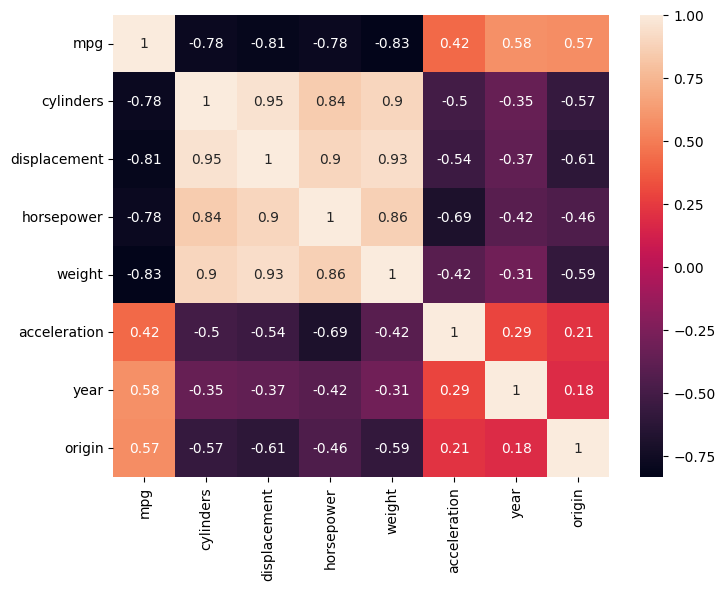

In [5]:
# i want heatmap 
num = auto.select_dtypes(include=['number'])
plt.figure(figsize=(8,6))
sns.heatmap(num.corr(), annot=True)
plt.show()

In [6]:
X = auto.drop(['mpg', 'name'], axis=1)  # All predictors except target and categorical
y = auto['mpg']

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())
# need to remove variables with p value > 0.05 
# remove each one and refit the model then check summary again and repeat until all p values < 0.05

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          2.04e-139
Time:                        14:26:47   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

### 2 -  Which variables would be removed from the model, and why?

In [7]:
auto2 = auto.drop(['cylinders', 'horsepower', 'acceleration'], axis=1)
X2 = auto2.drop(['mpg', 'name'], axis=1)
y2 = auto2['mpg']

X2_const = sm.add_constant(X2)
model2 = sm.OLS(y2, X2_const).fit()
print(model2.summary())

# now displacement has p value > 0.05, remove it too


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     435.1
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          9.57e-142
Time:                        14:26:47   Log-Likelihood:                -1027.2
No. Observations:                 392   AIC:                             2064.
Df Residuals:                     387   BIC:                             2084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -18.6065      4.028     -4.620   

In [8]:
auto3 = auto2.drop(['displacement'], axis=1)
X3 = auto3.drop(['mpg', 'name'], axis=1)
y3 = auto3['mpg']

X3_const = sm.add_constant(X3)
model3 = sm.OLS(y3, X3_const).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          7.26e-143
Time:                        14:26:47   Log-Likelihood:                -1027.8
No. Observations:                 392   AIC:                             2064.
Df Residuals:                     388   BIC:                             2080.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0459      4.001     -4.510      0.0

### 3 - Consider the origin column as a categorical variable where 1 = USA, 2 = Europe, 3 = Japan. Which origin has the greatest impact on fuel consumption (mpg)?

In [9]:
auto4 = auto3.copy()

auto4['origin'] = auto4['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# dummies for origin to separate 
origin_dummies = pd.get_dummies(auto4['origin'], drop_first=False, prefix='origin')
origin_dummies = origin_dummies.astype(int)

# drop origin_USA
origin_dummies = origin_dummies.drop(columns=['origin_USA'])

# add dummies to dataframe
auto4 = pd.concat([auto4, origin_dummies], axis=1)

auto4.head()
X = auto4[['weight', 'year', 'origin_Europe', 'origin_Japan']]
y = auto4['mpg']

X = sm.add_constant(X)
model4 = sm.OLS(y, X).fit()

print(model4.summary())

#o japao tem 2.21MPG mais do que os EUA
#ou seja se um carro dos EUA tiver 20MPG o japao tera 22.21MPG e o europa 21.15MPG


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     437.9
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          3.53e-142
Time:                        14:26:47   Log-Likelihood:                -1026.1
No. Observations:                 392   AIC:                             2062.
Df Residuals:                     387   BIC:                             2082.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -18.3069      4.017     -4.557

### 4 - What is the equation of the best model found?

In [10]:
#equation
#mpg = -18.0459 + -0.0060*weight + 0.7571*year + 1.150*origin

## Part 2: Logistic Regression

In [11]:
#load StudentPerformance.csv dataset
student = pd.read_csv('StudentPerformance.csv')
student

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


### 1 - Considering 'Performance Index' as the dependent variable, create a new column 'approved' where students with Performance Index >= 60 are considered approved (1) and the rest not approved (0). Drop the 'Performance Index' column afterwards.

In [12]:
student['approved'] = np.where(student['Performance Index'] >= 60, 1, 0)
student = student.drop(columns=['Performance Index'])
student

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,approved
0,7,99,Yes,9,1,1
1,4,82,No,4,2,1
2,8,51,Yes,7,2,0
3,5,52,Yes,5,2,0
4,7,75,No,8,5,1
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,0
9996,7,64,Yes,8,5,0
9997,6,83,Yes,8,5,1
9998,9,97,Yes,7,0,1


### 2 - Considering 'approved' as the dependent variable, find the best logistic regression model.

In [13]:
student.info()
# convert categorical variables to dummies extracurricular Activities
student = pd.get_dummies(student, columns=['Extracurricular Activities'], drop_first=True)
student['Extracurricular Activities_Yes'] = student['Extracurricular Activities_Yes'].astype(int)
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Hours Studied                     10000 non-null  int64 
 1   Previous Scores                   10000 non-null  int64 
 2   Extracurricular Activities        10000 non-null  object
 3   Sleep Hours                       10000 non-null  int64 
 4   Sample Question Papers Practiced  10000 non-null  int64 
 5   approved                          10000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 468.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Hours Studied                     10000 non-null  int64
 1   Previous Scores                   10000 non-null  

### 3 - Separate the dataset into train and test sets (70% train, 30% test). Calculate the accuracy of the model on the test set.

In [14]:
# Use the student dataframe (binary target 'approved') for classification
X = student.drop(columns=['approved'])
y = student['approved']

# Separate the dataset into train and test sets (70% train, 30% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# TRAINING
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

# PREDICTIONS
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

#print classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))



Accuracy: 0.972
F1 Score: 0.9668769716088328

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1721
           1       0.98      0.96      0.97      1279

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



### 4 - Create the confusion matrix for the test set predictions.

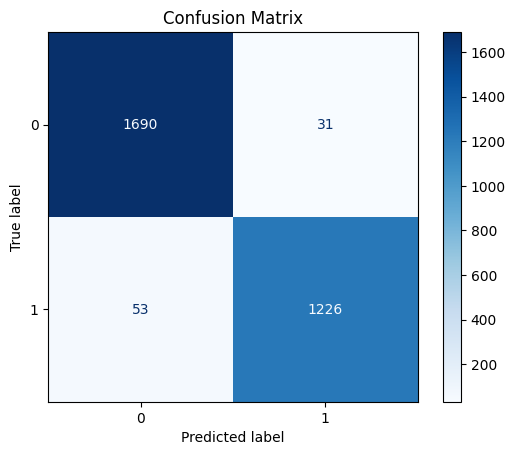

In [15]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### 5- According with the model which variables are significant to explain if a student is approved or not? Explain based on coefficients.

In [ ]:
# code here
# which variables are most important in predicting approval?
importance = pd.Series(model.coef_[0], index=X.columns)
importance = importance.sort_values(ascending=False)
print("Feature Importance:\n", importance)

# sao as horas de estudo e atividades extracurriculares

Feature Importance:
 Hours Studied                       2.694918
Previous Scores                     0.943745
Extracurricular Activities_Yes      0.788276
Sleep Hours                         0.400192
Sample Question Papers Practiced    0.201201
dtype: float64
